In [1]:
import numpy as np
import torch
import os
import sys
import math
import matplotlib.pyplot as plt

from my_utility import compute_Fourier_modes, compute_Fourier_bases

N = 1000
k = 1
t = np.linspace(0,2*np.pi,N, endpoint=False)
x = torch.from_numpy(np.array([k*np.cos(t), np.sin(t)]).T).unsqueeze(0)  #1,n,2
w = torch.from_numpy(np.linalg.norm(np.array([-k*np.sin(t), np.cos(t)]).T, axis = -1, keepdims = True)).unsqueeze(0).unsqueeze(-1)   #1,n,1,1


norm0 = np.array([np.cos(t), k*np.sin(t)]).T  # n,2
nx = torch.from_numpy(norm0/(np.linalg.norm(norm0, axis = -1, keepdims = True)) ).unsqueeze(0) #1,N,2
# nx = x/np.linalg.norm(x, axis = -1, keepdims = True)

def f(x):
    b,n,c = x.shape
    
    x, y = x[:,:,0], x[:,:,1]
    # fx = torch.sin(2*torch.pi*x)
    # fx = x + torch.exp(y)
    # fx = torch.abs(torch.sin((x**3 + y**3))) + torch.exp(y**3)
    # fx = torch.exp(torch.sin(x**2 + y**2) + torch.abs(x) + torch.abs(y))
    # fx = torch.exp(x**4 + y**4)/(1 + torch.log(1 + x**2 + y**2))

    fx = torch.ones_like(x)

    return fx.reshape(b,n)

k_max = 10
L = [4*k,4]
sigma0 = 0.1*k



# 直接计算系数

loss:  0.08499571129897586


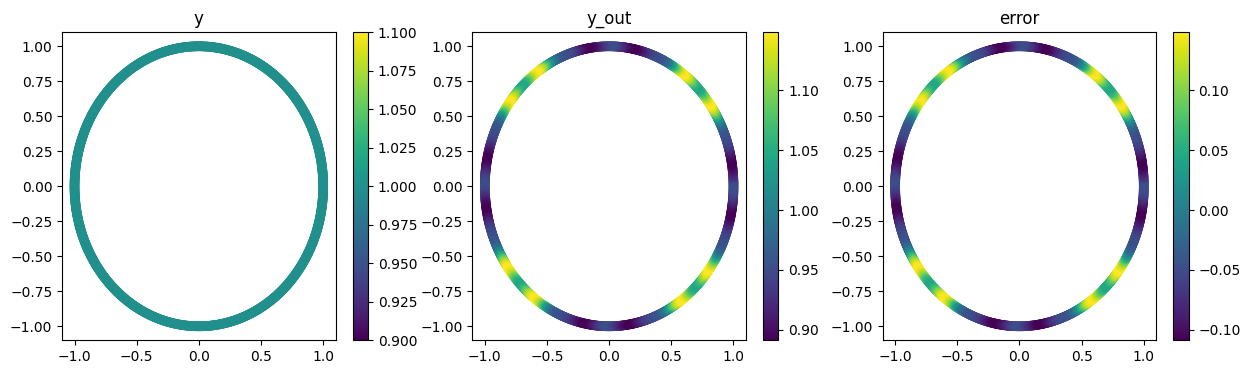

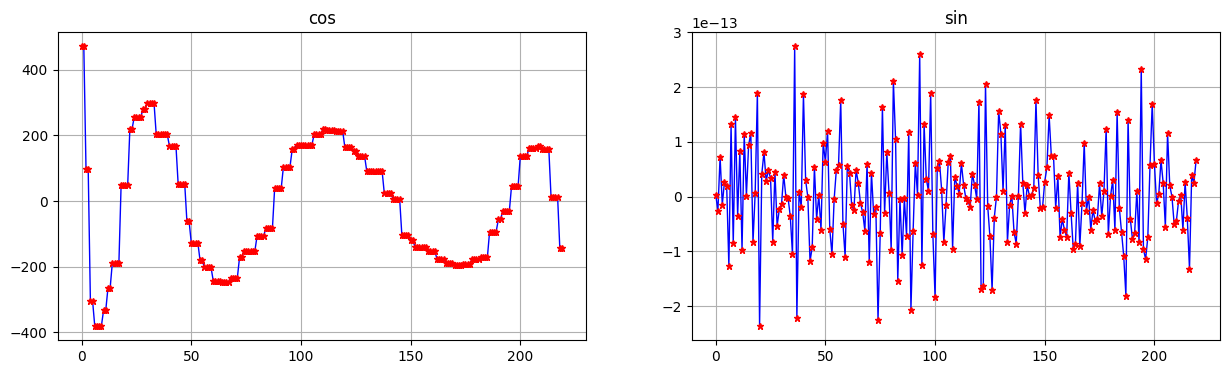

zero_hat:  1000.0


In [2]:

def decomposition_directly(x,y,w, k_max, L):
    '''
    x:  1, N, 2 
    y:  1, N 
    w:  1, N , 1 ,1

    return: 1, N 
    
    '''
    modes = torch.tensor(compute_Fourier_modes(2, [k_max,k_max], L))  # nmodes, 2, 1
    bases_c,  bases_s,  bases_0  = compute_Fourier_bases(x, modes)  # (1, n, nmodes, 1) , (1, n, nmodes, 1), (1, n, 1, 1)
    wbases_c,  wbases_s,  wbases_0 = bases_c*w,  bases_s*w,  bases_0*w

    f_c_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_c)
    f_s_hat = -torch.einsum("bx,bxkw->bkw", y, wbases_s)
    f_0_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_0)

    c_hat = [c.item() for c in f_c_hat[0,:,0]]
    s_hat = [s.item() for s in f_s_hat[0,:,0]]
    zero_hat = f_0_hat.item()
    # print(f_c_hat)
    # print(f_s_hat)
    # print(f_0_hat)
    y_out = torch.einsum("bkw,bxkw->bx", f_0_hat, bases_0)  + 2*torch.einsum("bkw,bxkw->bx", f_c_hat, bases_c) -  2*torch.einsum("bkw,bxkw->bx", f_s_hat, bases_s) 

    return y_out, [c_hat,s_hat,zero_hat]

y = f(x)
y_out, coffe_list = decomposition_directly(x, y, w, k_max, L)

# argmin_c ||y - c*y_out|| = <y, y_out>/||y_out||^2
coffe = torch.dot(y[0], y_out[0])/torch.norm(y_out[0])**2
y_out = y_out * coffe
print('loss: ', (torch.norm(y - y_out)/torch.norm(y)).item())


fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sc1 = axs[0].scatter(x[0,:,0], x[0,:,1],  
            c = y[0,:],
            cmap="viridis", 
            marker="o",)
axs[0].set_title("y")
fig.colorbar(sc1, ax=axs[0])


sc2 = axs[1].scatter(x[0,:,0], x[0,:,1],  
            c = y_out[0,:],
            cmap="viridis", 
            marker="o",)
axs[1].set_title("y_out")
fig.colorbar(sc2, ax=axs[1])

sc3 = axs[2].scatter(x[0,:,0], x[0,:,1],  
            c = y_out[0,:]-y[0,:],
            cmap="viridis", 
            marker="o",)
axs[2].set_title("error")
fig.colorbar(sc3, ax=axs[2])



fig1, axs1 = plt.subplots(1, 2, figsize=(15, 4))
axs1[0].plot(
    [i for i in range(len(coffe_list[0]))], 
    coffe_list[0], 
    marker='*', 
    linestyle="-",
    linewidth=1,
    color='blue',          # 线条颜色
    markerfacecolor='red', # 标记填充色
    markeredgecolor='red', # 标记边框色
    markersize=5,          # 标记尺寸（单位：磅）
    label="c"
)
axs1[1].plot(
    [i for i in range(len(coffe_list[1]))], 
    coffe_list[1], 
    marker='*', 
    linestyle="-",
    linewidth=1,
    color='blue',          # 线条颜色
    markerfacecolor='red', # 标记填充色
    markeredgecolor='red', # 标记边框色
    markersize=5,          # 标记尺寸（单位：磅）
    label="s"
)

axs1[0].grid(True)
axs1[0].set_title('cos')
axs1[1].grid(True)
axs1[1].set_title('sin')
plt.show()
print('zero_hat: ',coffe_list[2])

# 使用法向修正

sigma0 = 0.1, k_max = 10, L = [4, 4]
loss:  0.020280188927402798


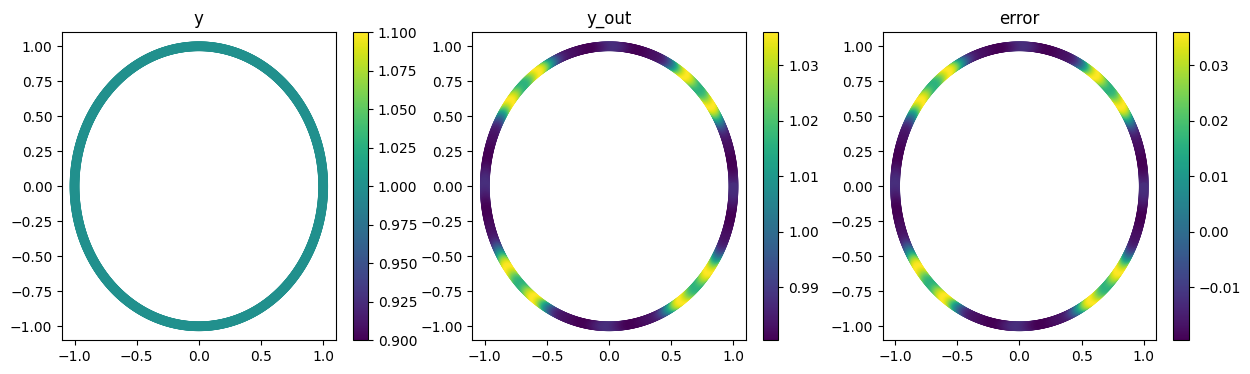

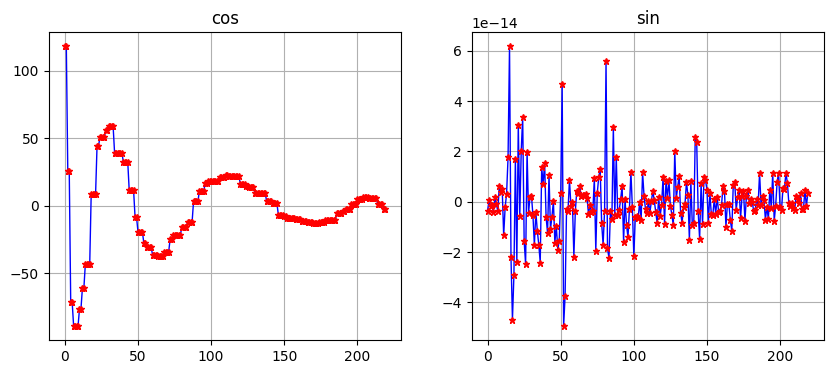

zero_hat:  250.66282746309966


In [3]:
def compute_correction_term(nx, modes, sigma):

    # temp : float[batch_size, nnodes, nmodes, nmeasures]
    temp  = torch.einsum("bxd,kdw->bxkw", nx, modes) 
    correction_nx = pow(2*np.pi*sigma**2, 1/2)*torch.exp(-sigma**2/2*temp**2)

    return correction_nx


def decomposition_tube(x, y, nx, w, sigma, k_max, L):


    modes = torch.tensor(compute_Fourier_modes(2, [k_max,k_max], L))  # nmodes, 2, 1
    bases_c,  bases_s,  bases_0  = compute_Fourier_bases(x, modes)  # (1, n, nmodes, 1) , (1, n, nmodes, 1), (1, n, 1, 1)

    wbases_c,  wbases_s,  wbases_0 = bases_c*w,  bases_s*w,  bases_0*w

    correction = compute_correction_term(nx, modes, sigma)
    wbases_c_cor = wbases_c * correction
    wbases_s_cor = wbases_s * correction
    wbases_0 = wbases_0 * pow(2*torch.pi*sigma**2, 1/2)
    

    f_c_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_c_cor)
    f_s_hat = -torch.einsum("bx,bxkw->bkw", y, wbases_s_cor)
    f_0_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_0)

    c_hat = [c.item() for c in f_c_hat[0,:,0]]
    s_hat = [s.item() for s in f_s_hat[0,:,0]]
    zero_hat = f_0_hat.item()
    
    y_out = torch.einsum("bkw,bxkw->bx", f_0_hat, bases_0)  + 2*torch.einsum("bkw,bxkw->bx", f_c_hat, bases_c) -  2*torch.einsum("bkw,bxkw->bx", f_s_hat, bases_s) 

    return y_out, [c_hat,s_hat,zero_hat]

print(f'sigma0 = {sigma0}, k_max = {k_max}, L = {L}')
y = f(x)
y_out_tube , coffe_list = decomposition_tube(x, y, nx, w, sigma0, k_max, L)
# argmin_c ||y - c*y_out|| = <y, y_out>/||y_out||^2
coffe = torch.dot(y[0], y_out_tube[0])/torch.norm(y_out_tube[0])**2
# print('coffe', coffe.item())
y_out_tube = y_out_tube * coffe

print('loss: ', (torch.norm(y - y_out_tube)/torch.norm(y)).item())

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sc1 = axs[0].scatter(x[0,:,0], x[0,:,1],  
            c = y[0,:],
            cmap="viridis", 
            marker="o",)
axs[0].set_title("y")
fig.colorbar(sc1, ax=axs[0])


sc2 = axs[1].scatter(x[0,:,0], x[0,:,1],  
            c = y_out_tube[0,:],
            cmap="viridis", 
            marker="o",)
axs[1].set_title("y_out")
fig.colorbar(sc2, ax=axs[1])

sc3 = axs[2].scatter(x[0,:,0], x[0,:,1],  
            c = y_out_tube[0,:] - y[0,:],
            cmap="viridis", 
            marker="o",)
axs[2].set_title("error")
fig.colorbar(sc3, ax=axs[2])



fig1, axs1 = plt.subplots(1, 2, figsize=(10, 4))
axs1[0].plot(
    [i for i in range(len(coffe_list[0]))], 
    coffe_list[0], 
    marker='*', 
    linestyle="-",
    linewidth=1,
    color='blue',          # 线条颜色
    markerfacecolor='red', # 标记填充色
    markeredgecolor='red', # 标记边框色
    markersize=5,          # 标记尺寸（单位：磅）
    label="c"
)
axs1[1].plot(
    [i for i in range(len(coffe_list[1]))], 
    coffe_list[1], 
    marker='*', 
    linestyle="-",
    linewidth=1,
    color='blue',          # 线条颜色
    markerfacecolor='red', # 标记填充色
    markeredgecolor='red', # 标记边框色
    markersize=5,          # 标记尺寸（单位：磅）
    label="s"
)

axs1[0].grid(True)
axs1[0].set_title('cos')
axs1[1].grid(True)
axs1[1].set_title('sin')
plt.show()
print('zero_hat: ',coffe_list[2])

# padding + 直接计算系数

sigma0 = 0.1, k_max = 10, L = [4, 4]
loss:  0.02028156703225097


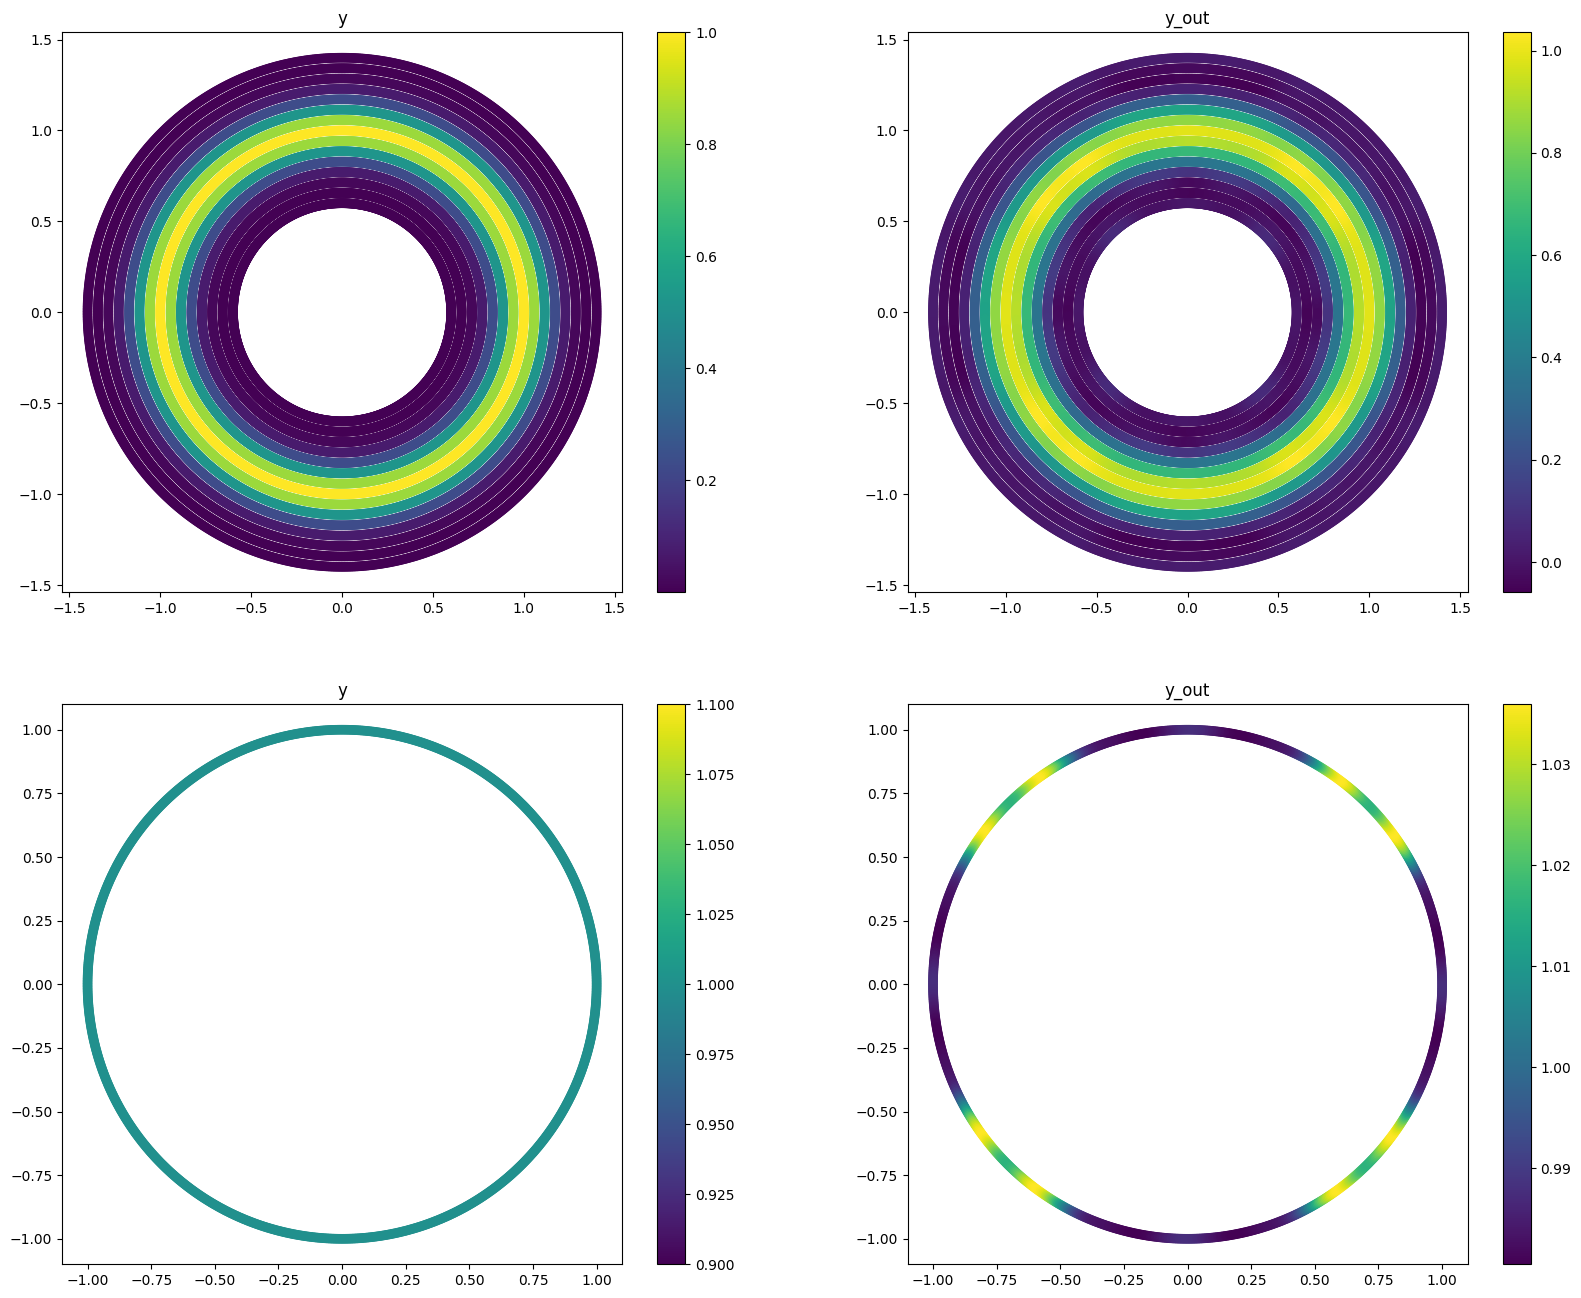

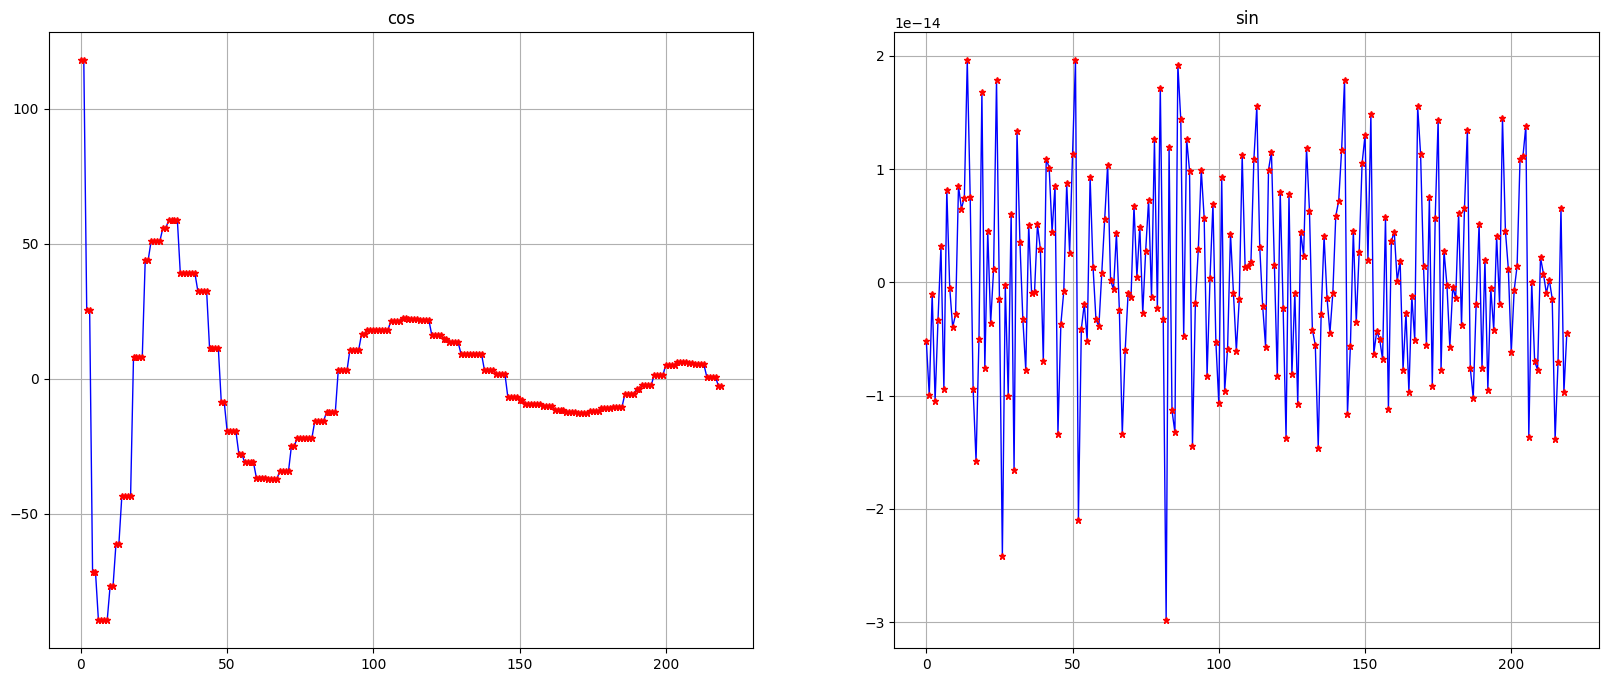

zero_hat:  250.6592997443131


In [4]:

print(f'sigma0 = {sigma0}, k_max = {k_max}, L = {L}')

def f_expend(x_in, sigma, r_list):
    '''
    x_in: num_r, N, n_dim
    r_list: num_r

    y: num_r, N, 1
    '''
    r,n,d = x_in.shape
    y1 = f(x_in[0:1,:]).repeat(len(r_list),1).unsqueeze(-1)
    y2 = torch.exp(-1/(2*sigma**2)*(torch.from_numpy(r_list.reshape(-1,1,1)))**2)
    y = y1*y2
    return y

r_list = np.linspace(-4*sigma0, 4*sigma0, 15)
r_step = r_list[1] - r_list[0]

x_expend = torch.from_numpy(np.array([x.squeeze().numpy() + r*nx.squeeze().numpy() for r in r_list]))
# print(x_expend.shape)  # 15,n,2

w0 = np.array([w.squeeze().numpy()*r_step for _ in range(len(r_list))])
w_expend = torch.from_numpy(w0).reshape(1,-1,1,1)  # 1,15*n,1,1
y = f_expend(x_expend, sigma0, r_list)  # 15,n,1
y = y.reshape(1,-1)  # 1,15*n
x_expend = x_expend.reshape(1,-1,2)

y_out, coffe_list = decomposition_directly(x_expend, y, w_expend, k_max, L)
norm = torch.norm(x_expend, dim = -1, keepdim=False)
mask = (norm > 1 - 1e-5) & (norm < 1 + 1e-5)

x_re = x_expend[0,7*N:8*N,:].clone()
y_out_re = y_out[0,7*N:8*N].clone()
y_re = y[0,7*N:8*N].clone()

# # print(y_out_restriction.shape)

# # argmin_c ||y - c*y_out|| = <y, y_out>/||y_out||^2
coffe = torch.dot(y_re, y_out_re)/torch.norm(y_out_re)**2
# # # print('coffe: ',coffe.item())
y_out_re = y_out_re * coffe
y_out = y_out * coffe

print('loss: ', (torch.norm(y_re - y_out_re)/torch.norm(y_re)).item())

fig, axs = plt.subplots(2, 2, figsize=(20, 16))
sc1 = axs[0,0].scatter(x_expend[0,:,0], x_expend[0,:,1],  
            c = y[0,:],
            cmap="viridis", 
            marker="o",)
axs[0,0].set_title("y")
axs[0,0].set_aspect('equal')
fig.colorbar(sc1, ax=axs[0,0])


sc2 = axs[0,1].scatter(x_expend[0,:,0], x_expend[0,:,1],  
            c = y_out[0,:],
            cmap="viridis", 
            marker="o",)
axs[0,1].set_title("y_out")
axs[0,1].set_aspect('equal')
fig.colorbar(sc2, ax=axs[0,1])


sc3 = axs[1,0].scatter(x_re[:,0], x_re[:,1],  
            c = y_re,
            cmap="viridis", 
            marker="o",)
axs[1,0].set_title("y")
axs[1,0].set_aspect('equal')
fig.colorbar(sc3, ax=axs[1,0])


sc4 = axs[1,1].scatter(x_re[:,0], x_re[:,1],  
            c = y_out_re,
            cmap="viridis", 
            marker="o",)
axs[1,1].set_title("y_out")
axs[1,1].set_aspect('equal')
fig.colorbar(sc4, ax=axs[1,1])


fig1, axs1 = plt.subplots(1, 2, figsize=(20, 8))
axs1[0].plot(
    [i for i in range(len(coffe_list[0]))], 
    coffe_list[0], 
    marker='*', 
    linestyle="-",
    linewidth=1,
    color='blue',          # 线条颜色
    markerfacecolor='red', # 标记填充色
    markeredgecolor='red', # 标记边框色
    markersize=5,          # 标记尺寸（单位：磅）
    label="c"
)
axs1[1].plot(
    [i for i in range(len(coffe_list[1]))], 
    coffe_list[1], 
    marker='*', 
    linestyle="-",
    linewidth=1,
    color='blue',          # 线条颜色
    markerfacecolor='red', # 标记填充色
    markeredgecolor='red', # 标记边框色
    markersize=5,          # 标记尺寸（单位：磅）
    label="s"
)
axs1[0].grid(True)
axs1[0].set_title('cos')
axs1[1].grid(True)
axs1[1].set_title('sin')

plt.show()
print('zero_hat: ',coffe_list[2])